<a href="https://colab.research.google.com/github/theHarshul/OptTripItin/blob/main/trip_planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopy

In [ ]:
pip install ortools

In [ ]:
import math
import pandas as pd
import numpy as np
import requests, json 
import matplotlib.pyplot as plt
from functools import reduce
from geopy import distance
from geopy.geocoders import Nominatim
from enum import Enum
from sklearn.cluster import KMeans
from sklearn.cluster._kmeans import _init_centroids # Using to initialize centroids for customized KMeans assignment
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.linear_solver import pywraplp

In [ ]:
def round_up_to_base(f,base):
    return math.ceil(f / base) * base
def Average(lst): 
    return reduce(lambda a, b: a + b, lst) / len(lst) 

In [ ]:
class Trip:

  def __init__(self, start_names, location_names):
    self.start_names = start_names       
    self.location_names = location_names 
    self.all_loc_names = self.start_names + self.location_names
    self.duration = len(start_names)

  def has_single_start_location(self):
    return all(loc == self.start_names[0] for loc in self.start_names)

  def get_num_unique_starting_locations(self):
    return len(set(start_names))

  def is_single_day_travel(self):
    return len(current_trip.start_names)==1

  def geocode_locations(self):
    locator = Nominatim(user_agent='h')
    self.locations = [locator.geocode(names) for names in self.all_loc_names]



In [ ]:
JAPAN=Trip(('Kyoto Century Hotel','Hotel Monterey Kyoto'),('Fushimi Inari Taisha', 'Giouji Temple, Kyoto', 'Kurumazaki Shrine', 'Nishiki Market','Tenryuji temple','Gion','Kiyomizu-dera','Ryōan-ji','Pontocho alley','Kyoto Imperial Palace','Kyoto International Manga Museum','Kinkaku-ji','Tetsugaku No Michi'))
JAPAN_TEST=Trip(('Kyoto Century Hotel',),('Fushimi Inari Taisha', 'Giouji Temple, Kyoto', 'Kurumazaki Shrine', 'Nishiki Market','Tenryuji temple','Gion','Kiyomizu-dera','Ryōan-ji','Pontocho alley'))

LA=Trip(('The Beverly Hills Hotel','The Beverly Hills Hotel'),('Malibu Pier','Universal Studios Hollywood','Griffith Observatory, Los Angeles', 'The Getty, Los Angeles', 'Santa Monica Pier', 'Hollywood Walk of Fame', '6333 W 3rd St, Los Angeles', '1351 3rd Street Promenade, Santa Monica', 'Los Angeles County Museum of Art'))
LA_ALT=Trip(('Four Seasons Hotel Westlake Village','The Beverly Hills Hotel'),('Malibu Pier','Universal Studios Hollywood','Griffith Observatory, Los Angeles', 'The Getty, Los Angeles', 'Santa Monica Pier', 'Hollywood Walk of Fame', '6333 W 3rd St, Los Angeles', '1351 3rd Street Promenade, Santa Monica', 'Los Angeles County Museum of Art'))
LA_ALT_2 = Trip(('Four Seasons Hotel Westlake Village','The Beverly Hills Hotel','Hilton Universal City'),('Malibu Pier','Universal Studios Hollywood','Griffith Observatory, Los Angeles', 'The Getty, Los Angeles', 'Santa Monica Pier', 'Hollywood Walk of Fame', '6333 W 3rd St, Los Angeles', '1351 3rd Street Promenade, Santa Monica', 'Los Angeles County Museum of Art'))


In [ ]:
current_trip = LA
current_trip.geocode_locations()

In [ ]:
d = {'Location': [locationName for locationName in current_trip.all_loc_names], 'Latitude': [location.latitude for location in current_trip.locations], 'Longitude': [location.longitude for location in current_trip.locations] }
df = pd.DataFrame(data=d)
df

,Location,Latitude,Longitude
0,The Beverly Hills Hotel,34.081766,-118.414693
1,The Beverly Hills Hotel,34.081766,-118.414693
2,Malibu Pier,34.036434,-118.676138
3,Universal Studios Hollywood,34.139136,-118.354277
4,"Griffith Observatory, Los Angeles",34.118219,-118.300293
5,"The Getty, Los Angeles",34.077017,-118.474010
6,Santa Monica Pier,34.008896,-118.497402
7,Hollywood Walk of Fame,34.101662,-118.341848
8,"6333 W 3rd St, Los Angeles",34.071947,-118.360246
9,"1351 3rd Street Promenade, Santa Monica",34.016998,-118.497653


In [ ]:
def plot_assignment(trip,assignment=None,centroids=None):
  fig = plt.figure()
  fig.set_size_inches(30, 15)
  lon = list(map(lambda loc: loc.latitude, trip.locations))
  lat = list(map(lambda loc: loc.longitude, trip.locations))
  plt.scatter(lon, lat, c=assignment)
  for x,y,label in zip(lon,lat, trip.all_loc_names):

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center
  
  if centroids is not None:
    for i in range(len(centroids)):
      plt.scatter(centroids[i][0], centroids[i][1])
      plt.annotate("MEAN " + str(i), # this is the text
                  (centroids[i][0], centroids[i][1]), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center
  fig.show()

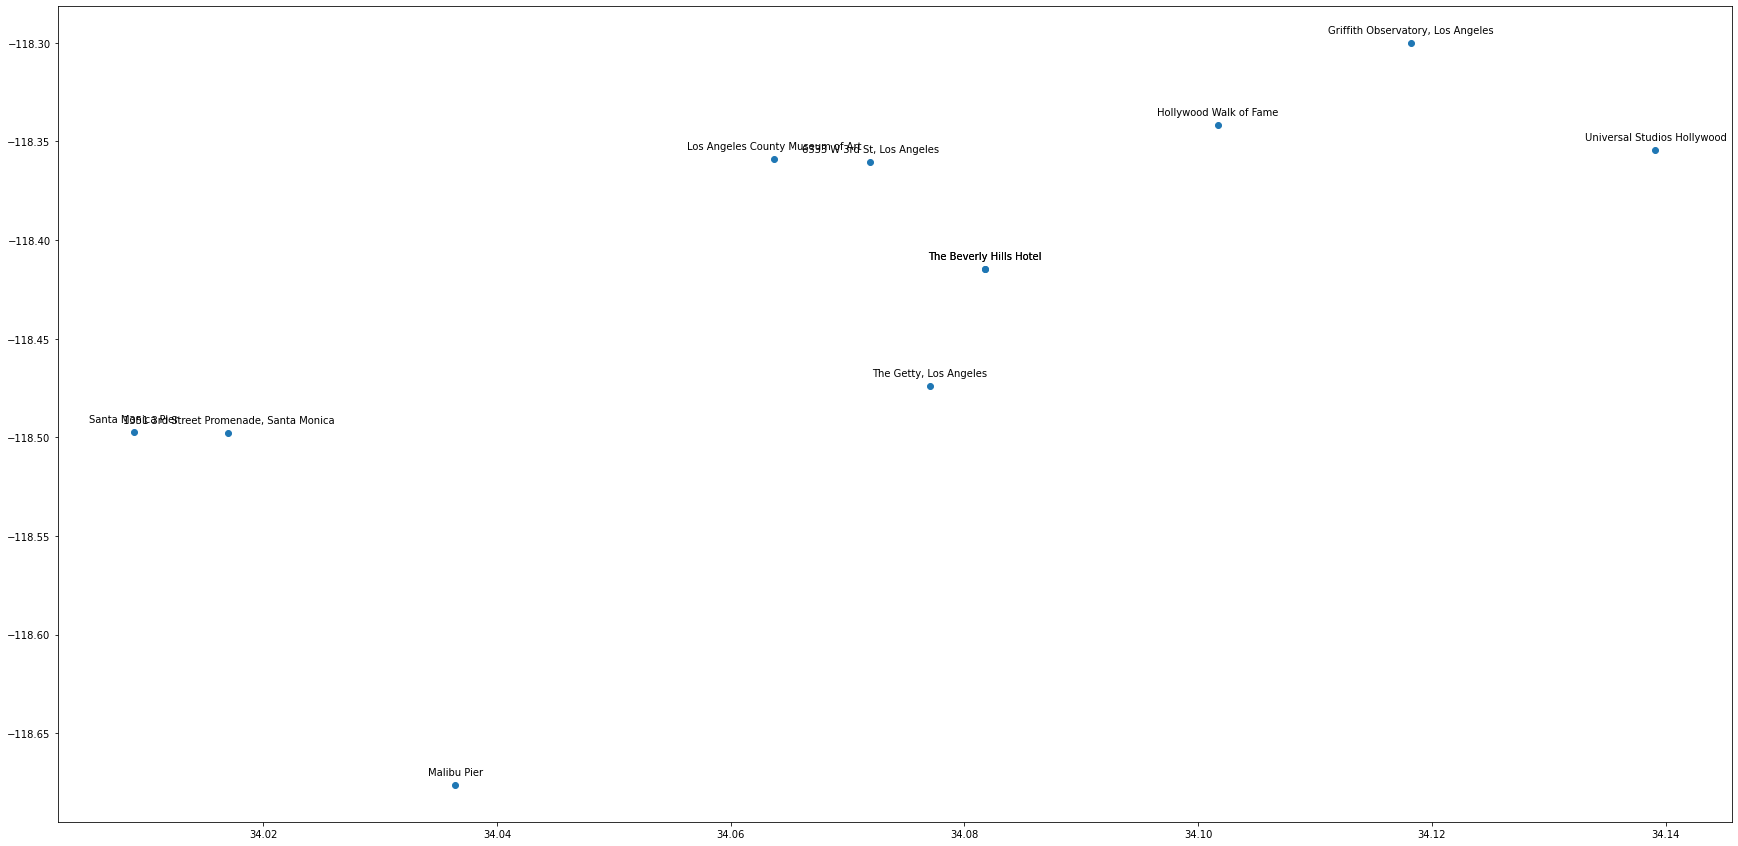

In [ ]:
plot_assignment(current_trip)

In [ ]:
def initialize_centroids(arr,num_centroids):
  #return [(df.iloc[i]['Latitude'],df.iloc[i]['Longitude']) for i in range(num_centroids)]
  return _init_centroids(arr, num_centroids, "k-means++")

In [ ]:
def distance_to_centroids(coords, num_centroids):
  cluster_dists = [[] for i in range(num_centroids)]
  # Compute distances from each example to each centroid
  for x,y in zip(coords[0],coords[1]):
    for i in range(num_centroids):
      cluster_dists[i].append(distance.distance((x,y),centers[i]).miles)
  return cluster_dists

In [ ]:
def construct_bipartite_graph(num_examples, num_centroids, num_clusters, cluster_dists):
  # Create bipartite graph in the form of a 2D matrix, where M[i][j] represents the weight (distance) of the edge of example i to centroid j
  # Each example will be assigned to one centroid such that there is an even number of assignments for each cluster 

  # The number of clusters will be a rounded up multiple of the number of examples. 
  # E.g. if we had 9 examples with 2 centroids and 9 potential matching cluster centers on the right side of the graph, we would have 4 examples assigned to each cluster. We would still have one remaining example which would automatically be assigned to the last cluster center. To have an even opportunity to optimize distance to all clusters, we would need another cluster center so 10 potential matching clusters.
  M = np.zeros((num_examples,num_clusters))
  for i in range(num_examples):
    for j in range(0,num_clusters,num_centroids):
      for k in range(num_centroids):
        if j + k >= M.shape[1]:
          break
        M[i][j+k] = cluster_dists[k][i]
  return M      

In [ ]:
def setup_mixed_integer_program(M,num_examples,num_clusters,num_centroids):
  x = {}
  solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                            pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
  print(num_clusters)
  for i in range(num_examples):
    for j in range(num_clusters):
      x[i, j] = solver.BoolVar('x[%i,%i]' % (i, j))
  solver.Minimize(solver.Sum([M[i][j] * x[i,j] for i in range(num_examples)
                                                    for j in range(num_clusters)]))
  # Each example is assigned to at most 1 cluster.
  for i in range(num_examples):
    solver.Add(solver.Sum([x[i, j] for j in range(num_clusters)]) == 1)

  # Each cluster is assigned to at most 1 example.
  for j in range(num_clusters):
    solver.Add(solver.Sum([x[i, j] for i in range(num_examples)]) <= 1)

  # Constraint that starting points cannot be in the same cluster
  for i in range(num_centroids):
    solver.Add(solver.Sum([x[i, j] for j in range(i,num_clusters,num_centroids) for i in range(num_centroids)]) <= 1)

  return x,solver

In [ ]:
def cluster_assignment(lat_lngs,centroids,num_examples):
  num_centroids = len(centroids)
  
  cluster_dists = distance_to_centroids(lat_lngs, num_centroids=num_centroids)

  num_clusters = round_up_to_base(num_examples,num_centroids)
  M = construct_bipartite_graph(num_examples,num_centroids,num_clusters,cluster_dists)

  # Create a Mixed Integer Program with constraints to minimize the total distance for each example from it's assigned centroid 
  x,solver = setup_mixed_integer_program(M,num_examples,num_clusters,num_centroids)

  sol = solver.Solve()
  print('Total cost = ', solver.Objective().Value())
  print()
  assignment=[]
  for i in range(num_examples):
    for j in range(num_clusters):
      if x[i, j].solution_value() > 0:
        assignment.append(j%num_centroids)
        print('Location %d assigned to cluster %d.  Cost = %f' % (
              i,
              j,
              M[i][j]))

  print()
  print("Time = ", solver.WallTime(), " milliseconds")
  
  return assignment, solver.Objective().Value()


In [ ]:
def compute_updated_centroids(lat_lngs, assignment, num_centroids):
  assigned_examples = [[] for i in range(num_centroids)]
  for x,y,i in zip(lat_lngs[0],lat_lngs[1],assignment):
    assigned_examples[i].append((x,y))

  updated_centroids = list(map(lambda x: (Average([a_tuple[0] for a_tuple in x]), Average([a_tuple[1] for a_tuple in x])), assigned_examples))
  return updated_centroids


12
Total cost =  63.41515094855896

Location 0 assigned to cluster 0.  Cost = 3.195218
Location 1 assigned to cluster 7.  Cost = 15.319916
Location 2 assigned to cluster 5.  Cost = 0.000000
Location 3 assigned to cluster 4.  Cost = 4.643678
Location 4 assigned to cluster 6.  Cost = 4.689336
Location 5 assigned to cluster 9.  Cost = 11.928107
Location 6 assigned to cluster 11.  Cost = 10.431797
Location 7 assigned to cluster 2.  Cost = 2.303932
Location 8 assigned to cluster 8.  Cost = 0.000000
Location 9 assigned to cluster 1.  Cost = 10.330018
Location 10 assigned to cluster 10.  Cost = 0.573149

Time =  10  milliseconds
12
Total cost =  38.15105103720996

Location 0 assigned to cluster 0.  Cost = 3.557816
Location 1 assigned to cluster 3.  Cost = 6.151364
Location 2 assigned to cluster 5.  Cost = 9.434416
Location 3 assigned to cluster 4.  Cost = 2.968793
Location 4 assigned to cluster 6.  Cost = 3.492484
Location 5 assigned to cluster 9.  Cost = 3.138995
Location 6 assigned to clust

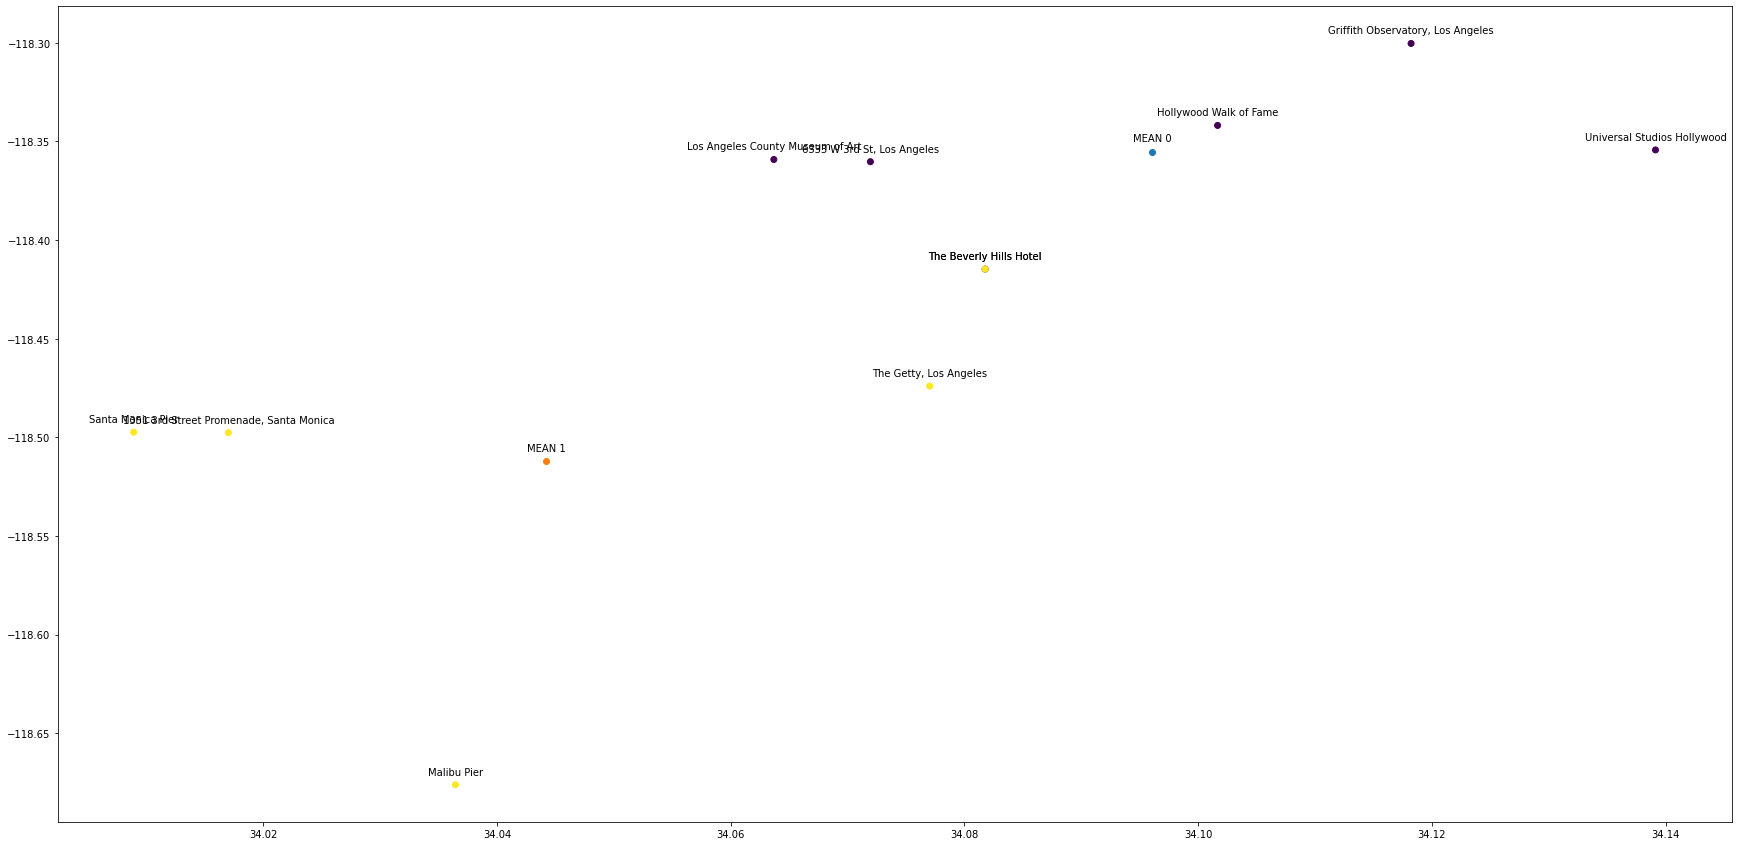

In [ ]:
previous_centers = None
min_cost = math.inf
opt_assignment = None
opt_centroids = None

num_examples = df.shape[0]
lat_lng_arr = df[['Latitude','Longitude']].values
lat_lng_tuple = (df['Latitude'],df['Longitude'])

for _ in range(10):
  if current_trip.is_single_day_travel():
    opt_assignment = [0] * len(lat_lng_arr)
    break
  centers = initialize_centroids(arr=lat_lng_arr,num_centroids=current_trip.duration)
  for _ in range(300):
    assignment, cost = cluster_assignment(lat_lng_tuple,centroids=centers,num_examples=num_examples)
    updated_centers = compute_updated_centroids(lat_lng_tuple,assignment = assignment, num_centroids = current_trip.duration)
    previous_centers = centers
    if np.array_equal(centers,updated_centers):
      print("found optimal centroids, cost = " + str(min_cost))
      if min_cost>cost:
        min_cost = cost
        opt_assignment = assignment
        opt_centroids = centers
      break
    else:
      centers = updated_centers
if not current_trip.is_single_day_travel():
  plot_assignment(current_trip,assignment=opt_assignment, centroids=opt_centroids)

Regular kMeans

In [ ]:
# kmeans = KMeans(n_clusters=current_trip.duration, verbose=1).fit(df.loc[:, df.columns != 'Location'])
# centroids = kmeans.cluster_centers_
# print(centroids)
# plt.scatter(df['Latitude'], df['Longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
# plt.show()

In [ ]:
def generate_idx_to_loc_names_map(indices,locationNames,assignment,label):
  print(indices)
  idx_map = {}
  for i in range(len(indices)):
      print(i)
      idx_map[i]= locationNames[indices[i]]
  return idx_map

In [ ]:
def generate_request_params(locationNames,indices):
  locations_to_visit=[locationNames[i] for i in indices]
  start_param = '|'.join(locations_to_visit)
  dest_param = start_param
  return start_param,dest_param

In [ ]:
def get_location_distances(start_param,dest_param,api_key):
  base_url ='https://maps.googleapis.com/maps/api/distancematrix/json?'
  
  r = requests.get(base_url+'units=imperial'+'&origins='+start_param+'&destinations='+dest_param+'&key='+api_key)                   
  response = r.json()

  return response

In [ ]:
def create_distance_matrix(response):
  print(response)
  num_locations = len(response['rows'])
  M = np.zeros((num_locations,num_locations))
  for row in range(M.shape[0]):
    for col in range(M.shape[1]):
      M[row,col] = response['rows'][row]['elements'][col]['duration']['value']
  return M    

In [ ]:
dist_matrices=[]
idx_maps = []
api_key='DISTANCE_MATRIX_API_KEY'

for label in np.unique(opt_assignment):
  
  indices = [i for i in range(len(opt_assignment)) if opt_assignment[i] == label]
  idx_map = generate_idx_to_loc_names_map(indices,current_trip.all_loc_names,opt_assignment,label)
  idx_maps.append(idx_map)

  start_param,dest_param = generate_request_params(current_trip.all_loc_names,indices)
  print('\n')
  print(start_param)
 
  response = get_location_distances(start_param,dest_param,api_key)
  print(response)
  M = create_distance_matrix(response)
  dist_matrices.append(M)

  

[0, 3, 4, 7, 8, 10]
0
1
2
3
4
5


The Beverly Hills Hotel|Universal Studios Hollywood|Griffith Observatory, Los Angeles|Hollywood Walk of Fame|6333 W 3rd St, Los Angeles|Los Angeles County Museum of Art
{'destination_addresses': ['9641 Sunset Blvd, Beverly Hills, CA 90210, USA', '100 Universal City Plaza, Universal City, CA 91608, USA', '2800 E Observatory Rd, Los Angeles, CA 90027, USA', 'Hollywood Boulevard, Vine St, Los Angeles, CA 90028, USA', '6333 W 3rd St, Los Angeles, CA 90036, USA', '5905 Wilshire Blvd, Los Angeles, CA 90036, USA'], 'origin_addresses': ['9641 Sunset Blvd, Beverly Hills, CA 90210, USA', '100 Universal City Plaza, Universal City, CA 91608, USA', '2800 E Observatory Rd, Los Angeles, CA 90027, USA', 'Hollywood Boulevard, Vine St, Los Angeles, CA 90028, USA', '6333 W 3rd St, Los Angeles, CA 90036, USA', '5905 Wilshire Blvd, Los Angeles, CA 90036, USA'], 'rows': [{'elements': [{'distance': {'text': '1 ft', 'value': 0}, 'duration': {'text': '1 min', 'value': 0}, 'sta

In [ ]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

In [ ]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} seconds'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        route.append(index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    route.append(manager.IndexToNode(index))
    plan_output += 'Route distance: {} seconds\n'.format(route_distance)
    print(plan_output)
    return route,route_distance

In [ ]:
data = {}
data['num_vehicles'] = 1
data['depot'] = 0
routes = []
route_names = []

for i in range(len(dist_matrices)):
  data['distance_matrix'] = dist_matrices[i]
  manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['depot'])
  routing = pywrapcp.RoutingModel(manager)
  transit_callback_index = routing.RegisterTransitCallback(distance_callback)
  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
  search_parameters = pywrapcp.DefaultRoutingSearchParameters()
  search_parameters.first_solution_strategy = (
      routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
  solution = routing.SolveWithParameters(search_parameters)
  if solution:
      route,cost = print_solution(manager, routing, solution)
      print(route)
      print(idx_maps[i])
      [print(idx_maps[i][j]) for j in route]
      routes.append(route)
      route_names.append([(idx_maps[i][j]) for j in route])

Objective: 5678 seconds
Route for vehicle 0:
 0 -> 4 -> 5 -> 3 -> 2 -> 1 -> 0
Route distance: 5678 seconds

[0, 4, 5, 3, 2, 1, 0]
{0: 'The Beverly Hills Hotel', 1: 'Universal Studios Hollywood', 2: 'Griffith Observatory, Los Angeles', 3: 'Hollywood Walk of Fame', 4: '6333 W 3rd St, Los Angeles', 5: 'Los Angeles County Museum of Art'}
The Beverly Hills Hotel
6333 W 3rd St, Los Angeles
Los Angeles County Museum of Art
Hollywood Walk of Fame
Griffith Observatory, Los Angeles
Universal Studios Hollywood
The Beverly Hills Hotel
Objective: 5419 seconds
Route for vehicle 0:
 0 -> 2 -> 4 -> 3 -> 1 -> 0
Route distance: 5419 seconds

[0, 2, 4, 3, 1, 0]
{0: 'The Beverly Hills Hotel', 1: 'Malibu Pier', 2: 'The Getty, Los Angeles', 3: 'Santa Monica Pier', 4: '1351 3rd Street Promenade, Santa Monica'}
The Beverly Hills Hotel
The Getty, Los Angeles
1351 3rd Street Promenade, Santa Monica
Santa Monica Pier
Malibu Pier
The Beverly Hills Hotel


In [ ]:
route_names

[['The Beverly Hills Hotel',
  '6333 W 3rd St, Los Angeles',
  'Los Angeles County Museum of Art',
  'Hollywood Walk of Fame',
  'Griffith Observatory, Los Angeles',
  'Universal Studios Hollywood',
  'The Beverly Hills Hotel'],
 ['The Beverly Hills Hotel',
  'The Getty, Los Angeles',
  '1351 3rd Street Promenade, Santa Monica',
  'Santa Monica Pier',
  'Malibu Pier',
  'The Beverly Hills Hotel']]